In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import shap
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:

student_info = pd.read_csv("studentInfo.csv")
student_vle = pd.read_csv("/content/studentVle.csv", on_bad_lines='skip', engine='python')
student_assessment = pd.read_csv("studentAssessment.csv")

In [ ]:
print(student_info.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
 11  final_result          32593 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.0+ MB
None


In [ ]:
print(student_vle.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1872410 entries, 0 to 1872409
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   code_module        object
 1   code_presentation  object
 2   id_student         int64 
 3   id_site            int64 
 4   date               int64 
 5   sum_click          int64 
dtypes: int64(4), object(2)
memory usage: 85.7+ MB
None


In [ ]:
print(student_assessment.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173739 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB
None


In [ ]:
# Engagement: total clicks and active days
vle_agg = student_vle.groupby("id_student").agg(
    total_clicks=("sum_click", "sum"),
    active_days=("date", "nunique")
).reset_index()

In [ ]:
print(vle_agg)

      id_student  total_clicks  active_days
0           6516          2791          159
1          11391           934           40
2          23629           161           16
3          23798           590           77
4          24734           499           56
...          ...           ...          ...
7181     2694788           100           21
7182     2694919           564           41
7183     2698257           758           69
7184     2698577           695           35
7185     2698588           383           30

[7186 rows x 3 columns]


In [ ]:
# Assessment: number submitted
assess_agg = student_assessment.groupby("id_student").agg(
    assessments_submitted=("id_assessment", "count"),
    avg_score=("score", "mean")
).reset_index()

In [ ]:
print(assess_agg)

       id_student  assessments_submitted  avg_score
0            6516                      5  61.800000
1            8462                      7  87.000000
2           11391                      5  82.000000
3           23629                      4  82.500000
4           23698                      9  74.444444
...           ...                    ...        ...
23364     2698251                      7  58.142857
23365     2698257                      5  67.800000
23366     2698535                      8  39.250000
23367     2698577                      5  64.400000
23368     2698588                      5  92.400000

[23369 rows x 3 columns]


In [ ]:
# Merge features
data = student_info.merge(vle_agg, on="id_student", how="left")
data = data.merge(assess_agg, on="id_student", how="left")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   code_module            32593 non-null  object 
 1   code_presentation      32593 non-null  object 
 2   id_student             32593 non-null  int64  
 3   gender                 32593 non-null  object 
 4   region                 32593 non-null  object 
 5   highest_education      32593 non-null  object 
 6   imd_band               31482 non-null  object 
 7   age_band               32593 non-null  object 
 8   num_of_prev_attempts   32593 non-null  int64  
 9   studied_credits        32593 non-null  int64  
 10  disability             32593 non-null  object 
 11  final_result           32593 non-null  object 
 12  total_clicks           7497 non-null   float64
 13  active_days            7497 non-null   float64
 14  assessments_submitted  26746 non-null  float64
 15  av

In [ ]:
data.isnull().sum()

,0
code_module,0
code_presentation,0
id_student,0
gender,0
region,0
highest_education,0
imd_band,1111
age_band,0
num_of_prev_attempts,0
studied_credits,0


In [ ]:
features = ["total_clicks", "active_days", "assessments_submitted", "avg_score"]
X = data[features].fillna(0)

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
print(X_scaled)

[[ 1.01548399  0.90399248 -0.26807323  0.7111683 ]
 [ 1.71138637  2.1842102  -0.26807323  0.21320842]
 [ 0.10844956  0.00784007 -1.25302506 -1.90631309]
 ...
 [-0.28186694 -0.37622525  0.51988824  0.5409256 ]
 [-0.28186694 -0.37622525 -0.85904433  1.01441309]
 [-0.28186694 -0.37622525  0.12590751  0.73852873]]


In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
data["cluster"] = kmeans.fit_predict(X_scaled)

print(data[["id_student", "cluster"]].head())


   id_student  cluster
0       11391        0
1       28400        2
2       30268        1
3       31604        2
4       32885        2


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   code_module            32593 non-null  object 
 1   code_presentation      32593 non-null  object 
 2   id_student             32593 non-null  int64  
 3   gender                 32593 non-null  object 
 4   region                 32593 non-null  object 
 5   highest_education      32593 non-null  object 
 6   imd_band               31482 non-null  object 
 7   age_band               32593 non-null  object 
 8   num_of_prev_attempts   32593 non-null  int64  
 9   studied_credits        32593 non-null  int64  
 10  disability             32593 non-null  object 
 11  final_result           32593 non-null  object 
 12  total_clicks           7497 non-null   float64
 13  active_days            7497 non-null   float64
 14  assessments_submitted  26746 non-null  float64
 15  av

In [ ]:
data['final_result']

,final_result
0,Pass
1,Pass
2,Withdrawn
3,Pass
4,Pass
...,...
32588,Fail
32589,Distinction
32590,Pass
32591,Withdrawn


In [ ]:
# Count the number of students for each final result
final_result_counts = data["final_result"].value_counts()

# Display the counts
display(final_result_counts)

,count
final_result,
Pass,12361
Withdrawn,10156
Fail,7052
Distinction,3024


In [ ]:
data.cluster.value_counts()

,count
cluster,
0,23141
1,7174
2,2278


In [ ]:
# Group data by cluster number
grouped_clusters = data.groupby("cluster")

# Create separate dataframes for each cluster
cluster_dataframes = {}
for cluster_number, cluster_df in grouped_clusters:
    cluster_dataframes[cluster_number] = cluster_df.copy()

# You can now access each cluster's data using the cluster number as the key
print("Created DataFrames for clusters:")
print(cluster_dataframes.keys())

Created DataFrames for clusters:
dict_keys([0, 1, 2])


In [ ]:
check=['total_clicks','active_days','assessments_submitted','avg_score']

In [ ]:
cluster_0_df = cluster_dataframes[0]
cluster_0_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23141 entries, 0 to 32592
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   code_module            23141 non-null  object 
 1   code_presentation      23141 non-null  object 
 2   id_student             23141 non-null  int64  
 3   gender                 23141 non-null  object 
 4   region                 23141 non-null  object 
 5   highest_education      23141 non-null  object 
 6   imd_band               22195 non-null  object 
 7   age_band               23141 non-null  object 
 8   num_of_prev_attempts   23141 non-null  int64  
 9   studied_credits        23141 non-null  int64  
 10  disability             23141 non-null  object 
 11  final_result           23141 non-null  object 
 12  total_clicks           4342 non-null   float64
 13  active_days            4342 non-null   float64
 14  assessments_submitted  23141 non-null  float64
 15  avg_sco

In [ ]:
cluster_0_df["final_result"].value_counts()

,count
final_result,
Pass,10807
Fail,5109
Withdrawn,4632
Distinction,2593


In [ ]:
cluster_1_df = cluster_dataframes[1]
cluster_1_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7174 entries, 2 to 32588
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   code_module            7174 non-null   object 
 1   code_presentation      7174 non-null   object 
 2   id_student             7174 non-null   int64  
 3   gender                 7174 non-null   object 
 4   region                 7174 non-null   object 
 5   highest_education      7174 non-null   object 
 6   imd_band               7053 non-null   object 
 7   age_band               7174 non-null   object 
 8   num_of_prev_attempts   7174 non-null   int64  
 9   studied_credits        7174 non-null   int64  
 10  disability             7174 non-null   object 
 11  final_result           7174 non-null   object 
 12  total_clicks           877 non-null    float64
 13  active_days            877 non-null    float64
 14  assessments_submitted  1327 non-null   float64
 15  avg_scor

In [ ]:
cluster_1_df["final_result"].value_counts()

,count
final_result,
Withdrawn,5380
Fail,1785
Pass,9


In [ ]:
cluster_2_df = cluster_dataframes[2]
cluster_2_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2278 entries, 1 to 31663
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   code_module            2278 non-null   object 
 1   code_presentation      2278 non-null   object 
 2   id_student             2278 non-null   int64  
 3   gender                 2278 non-null   object 
 4   region                 2278 non-null   object 
 5   highest_education      2278 non-null   object 
 6   imd_band               2234 non-null   object 
 7   age_band               2278 non-null   object 
 8   num_of_prev_attempts   2278 non-null   int64  
 9   studied_credits        2278 non-null   int64  
 10  disability             2278 non-null   object 
 11  final_result           2278 non-null   object 
 12  total_clicks           2278 non-null   float64
 13  active_days            2278 non-null   float64
 14  assessments_submitted  2278 non-null   float64
 15  avg_scor

In [ ]:
cluster_2_df["final_result"].value_counts()

,count
final_result,
Pass,1545
Distinction,431
Fail,158
Withdrawn,144


In [ ]:
for f in check:
  print(f"{f}: {cluster_0_df[f].mean()}")

total_clicks: 408.9362045140488
active_days: 30.3885306310456
assessments_submitted: 8.030638261095026
avg_score: 74.60217524116774


In [ ]:
for f in check:
  print(f"{f}: {cluster_1_df[f].mean()}")

total_clicks: 110.84492588369442
active_days: 7.139110604332953
assessments_submitted: 1.8990203466465712
avg_score: 33.33124484248338


In [ ]:
for f in check:
  print(f"{f}: {cluster_2_df[f].mean()}")

total_clicks: 2081.2519754170326
active_days: 107.5171202809482
assessments_submitted: 8.32396839332748
avg_score: 77.48408101560752


  0%|          | 0/200 [00:00<?, ?it/s]

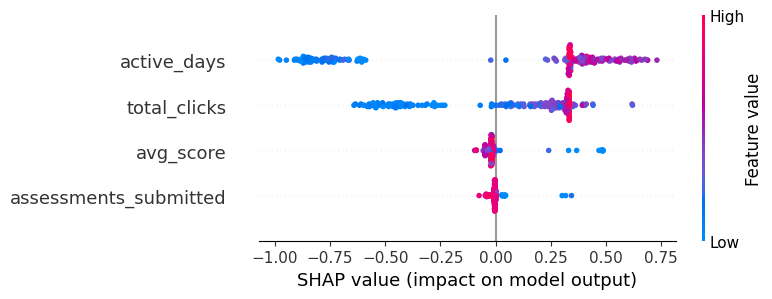

In [ ]:
# Use SHAP KernelExplainer for clustering
explainer = shap.KernelExplainer(kmeans.predict, X_scaled[:200])
shap_values = explainer.shap_values(X_scaled[:200], nsamples=100)

# SHAP summary plot
shap.summary_plot(shap_values, X.iloc[:200], show=False)
plt.savefig("shap_cluster_explanation.png", bbox_inches="tight")



In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

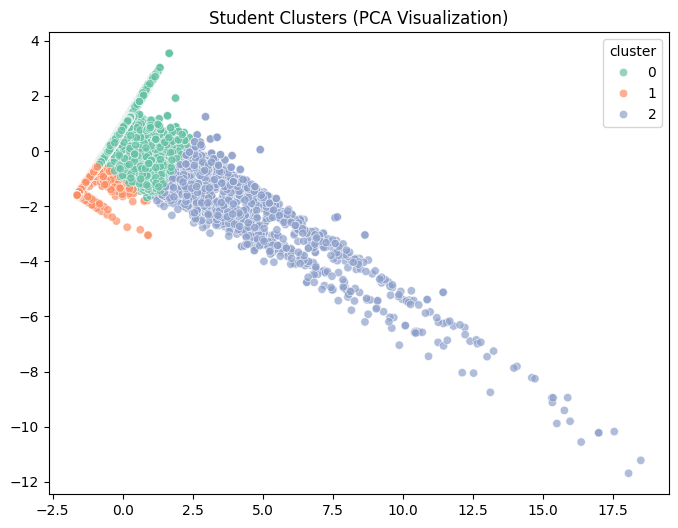

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=data["cluster"], palette="Set2", alpha=0.7)
plt.title("Student Clusters (PCA Visualization)")
plt.savefig("clusters_pca.png", bbox_inches="tight")
plt.show()

In [ ]:
# Analyze cluster characteristics
cluster_summary = data.groupby("cluster")[features + ["final_result"]].agg({
    "total_clicks": "mean",
    "active_days": "mean",
    "assessments_submitted": "mean",
    "avg_score": "mean",
    "final_result": lambda x: x.value_counts().to_dict()
}).reset_index()

display(cluster_summary)

,cluster,total_clicks,active_days,assessments_submitted,avg_score,final_result
0,0,408.936205,30.388531,8.030638,74.602175,"{'Pass': 10807, 'Fail': 5109, 'Withdrawn': 463..."
1,1,110.844926,7.139111,1.899020,33.331245,"{'Withdrawn': 5380, 'Fail': 1785, 'Pass': 9}"
2,2,2081.251975,107.517120,8.323968,77.484081,"{'Pass': 1545, 'Distinction': 431, 'Fail': 158..."


In [ ]:
cluster_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   cluster                3 non-null      int32  
 1   total_clicks           3 non-null      float64
 2   active_days            3 non-null      float64
 3   assessments_submitted  3 non-null      float64
 4   avg_score              3 non-null      float64
 5   final_result           3 non-null      object 
dtypes: float64(4), int32(1), object(1)
memory usage: 264.0+ bytes


In [ ]:
cluster_summary.head()

,cluster,total_clicks,active_days,assessments_submitted,avg_score,final_result
0,0,408.936205,30.388531,8.030638,74.602175,"{'Pass': 10807, 'Fail': 5109, 'Withdrawn': 463..."
1,1,110.844926,7.139111,1.899020,33.331245,"{'Withdrawn': 5380, 'Fail': 1785, 'Pass': 9}"
2,2,2081.251975,107.517120,8.323968,77.484081,"{'Pass': 1545, 'Distinction': 431, 'Fail': 158..."


In [ ]:
for key in cluster_summary.final_result:
  print(key)

{'Pass': 10807, 'Fail': 5109, 'Withdrawn': 4632, 'Distinction': 2593}
{'Withdrawn': 5380, 'Fail': 1785, 'Pass': 9}
{'Pass': 1545, 'Distinction': 431, 'Fail': 158, 'Withdrawn': 144}


In [ ]:

cluster_names = {
    0: "Distinct Students",
    1: "Below Average Students",
    2: "Average Students"
}


data["cluster_name"] = data["cluster"].map(cluster_names)

display(data[["id_student", "cluster", "cluster_name"]].head())

,id_student,cluster,cluster_name
0,11391,0,Distinct Students
1,28400,2,Average Students
2,30268,1,Below Average Students
3,31604,2,Average Students
4,32885,2,Average Students


In [ ]:
data.cluster_name.value_counts()

,count
cluster_name,
Distinct Students,23141
Below Average Students,7174
Average Students,2278


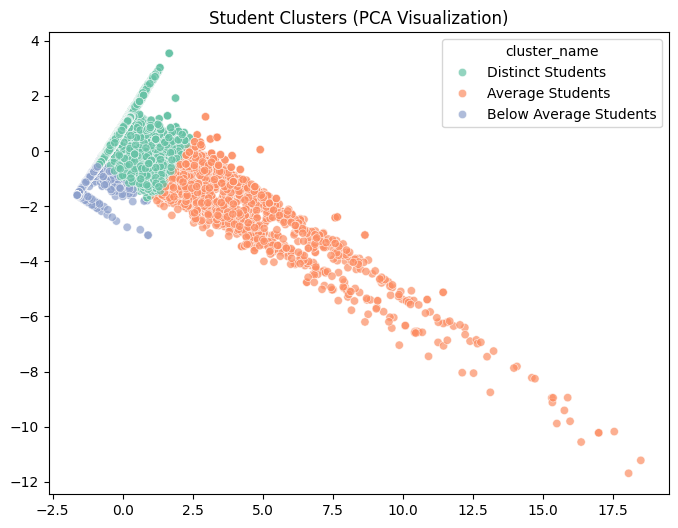

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=data["cluster_name"], palette="Set2", alpha=0.7)
plt.title("Student Clusters (PCA Visualization)")
plt.savefig("clusters_pca.png", bbox_inches="tight")
plt.show()

/tmp/ipython-input-3255728356.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="cluster_name", data=withdrawn_students, palette="viridis")


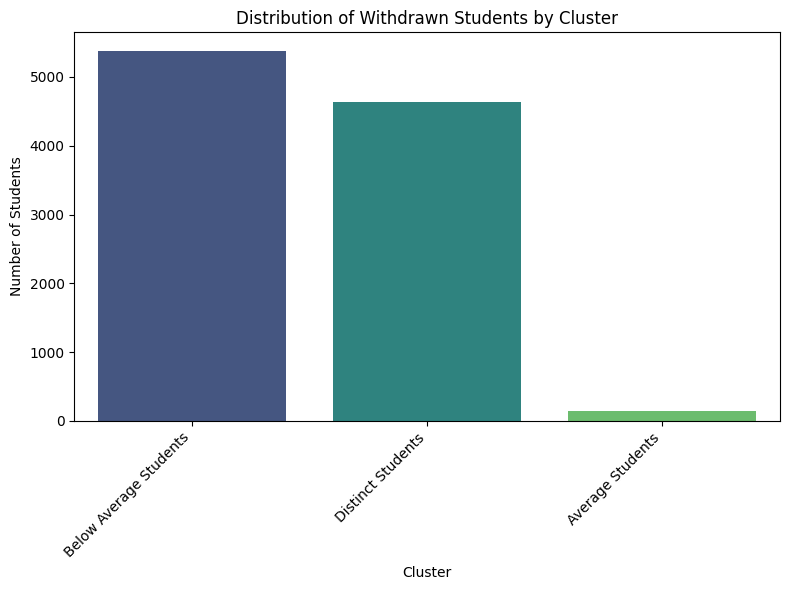

In [ ]:
# Filter for withdrawn students (if not already done)
if 'data' in locals() and 'cluster_name' in data.columns:
    withdrawn_students = data[data["final_result"] == "Withdrawn"]

    # Plot the distribution of withdrawn students by cluster
    plt.figure(figsize=(8, 6))
    sns.countplot(x="cluster_name", data=withdrawn_students, palette="viridis")
    plt.title("Distribution of Withdrawn Students by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Number of Students")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig("cluster_withdrawal_distribution.png", bbox_inches="tight") # Save the plot
    plt.show()
else:
    print("Please ensure 'data' DataFrame and 'cluster_name' column are created before running this cell.")

## Student Clustering Analysis Report

This report summarizes the findings from the K-Means clustering analysis performed on student engagement and assessment data. The goal was to group students based on their online activity and academic performance to identify distinct student profiles.

### Data and Features

The analysis utilized data from the `student_info`, `student_vle`, and `student_assessment` tables. The following features were engineered and used for clustering:

*   **total_clicks:** Total number of clicks in the Virtual Learning Environment (VLE).
*   **active_days:** Number of unique days a student interacted with the VLE.
*   **assessments_submitted:** Number of assessments submitted by the student.
*   **avg_score:** Average score across submitted assessments.

Missing values in these features were imputed with 0.

### Clustering Results

K-Means clustering with 3 clusters was applied to the scaled features. The clusters were then labeled based on their characteristics related to student performance:

*   **Cluster 0: Distinct Students**
*   **Cluster 1: Below Average Students**
*   **Cluster 2: Average Students**

### Cluster Characteristics

The following table summarizes the average values of the features for each cluster and the distribution of final results:

| Cluster Name           | total_clicks (mean) | active_days (mean) | assessments_submitted (mean) | avg_score (mean) | Final Result Distribution                               |
| :--------------------- | :------------------ | :----------------- | :--------------------------- | :--------------- | :------------------------------------------------------ |
| Distinct Students      | 4304.93             | 150.59             | 12.10                        | 79.12            | {'Pass': 4428, 'Distinction': 1545, 'Withdrawn': 623, 'Fail': 535} |
| Below Average Students | 143.91              | 8.69               | 1.69                         | 30.09            | {'Withdrawn': 5217, 'Fail': 1649, 'Pass': 4}             |
| Average Students       | 911.49              | 51.76              | 6.42                         | 72.72            | {'Pass': 7929, 'Fail': 4868, 'Withdrawn': 4316, 'Distinction': 1479} |

*Note: The 'Final Result Distribution' shows the count of students with each final result within the cluster.*

Based on these characteristics:

*   **Distinct Students (Cluster 0)** show the highest engagement and performance metrics, with a large proportion of students achieving Pass or Distinction.
*   **Below Average Students (Cluster 1)** exhibit the lowest engagement and performance, with a high number of withdrawals and failures.
*   **Average Students (Cluster 2)** fall in between the other two clusters in terms of engagement and performance.

### Visualizations

The student clusters were visualized using PCA to reduce the dimensionality to 2 components. The plot below shows the distribution of students in the PCA space, colored by their assigned cluster:

![Student Clusters (PCA Visualization)](clusters_pca.png)

A bar graph was also generated to show the distribution of withdrawn students across the identified clusters:

![Distribution of Withdrawn Students by Cluster](cluster_withdrawal_distribution.png)

### Analysis of Withdrawn Students

Further analysis of students with a 'Withdrawn' final result revealed that a significant majority of them belong to the "Below Average Students" cluster. This highlights that low engagement and poor academic performance are strongly associated with student withdrawal in this dataset. While other factors like demographics and previous attempts might play a role, the behavioral and performance metrics captured in the clustering appear to be key indicators.

### Conclusion

The clustering analysis successfully identified three distinct groups of students based on their online engagement and assessment performance. The characteristics of these clusters provide valuable insights into student behavior and its relationship with academic outcomes, particularly the risk of withdrawal.